<a href="https://colab.research.google.com/github/Ousmane-prog/Medical-AI/blob/master/Copie_de_MedicalAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
import shutil
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
#resnet
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
finding = "Cardiomegaly"

In [ ]:
!git clone https://github.com/adleberg/medical-ai.git

Cloning into 'medical-ai'...
remote: Enumerating objects: 1868, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1868 (delta 0), reused 0 (delta 0), pack-reused 1865
Receiving objects: 100% (1868/1868), 235.85 MiB | 15.65 MiB/s, done.
Updating files: 100% (1862/1862), done.


In [ ]:
df = pd.read_csv('/content/medical-ai/labels.csv')
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [ ]:
positives = df.loc[df['label'] == finding]
negatives = df.loc[df['label'] == "No Finding"]
n = len(positives)
print(n)

146


In [ ]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
TRAIN_N = int(n * TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [ ]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_lables = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

In [ ]:
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [ ]:
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:TRAIN_N+30].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

In [ ]:
def load_image_into_numpy_array(image):
    return np.array(image)

positive_image, negative_image = [], []
image_hight, image_width = 256, 256
for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((image_hight, image_width))
  positive_image.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
    image_path = rootdir+row["filename"]
    image = Image.open(image_path).resize((image_hight, image_width))
    negative_image.append(load_image_into_numpy_array(image))



Text(0.5, 0.98, 'Cardiomegaly')

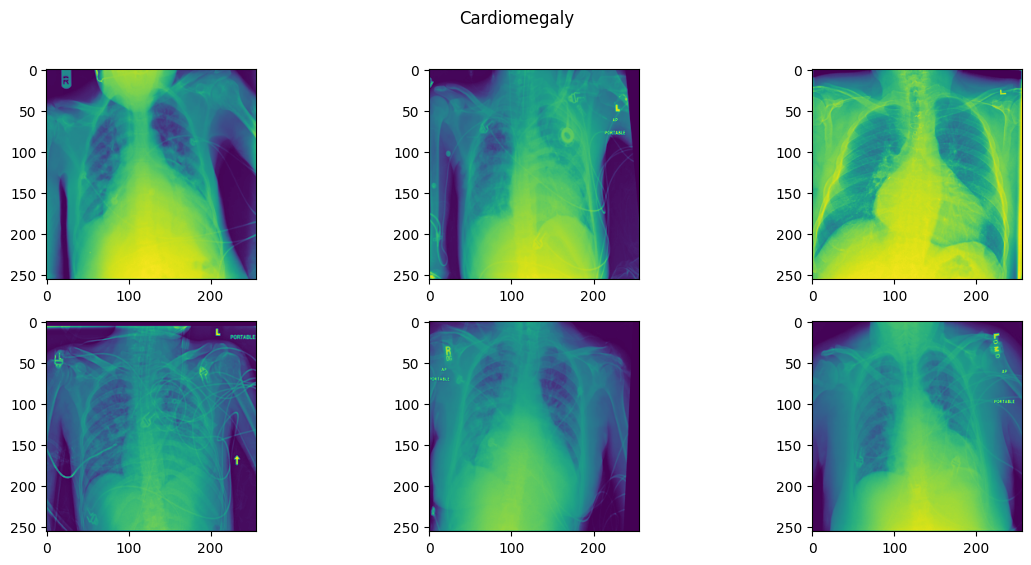

In [ ]:
# for idx, img in enumerate(positive_image[:6]):
#     plt.subplot(2,3,idx+1)
#     plt.title("finding")
#     plt.imshow(positive_image[idx])
# plt.show()
# for idx, img in enumerate(negative_image[:6]):
#     plt.subplot(2,3,idx+1)
#     plt.title("No finding")
#     plt.imshow(negative_image[idx])
# plt.show()
plot_object1 = plt.subplots(nrows=2, ncols=3, figsize = (14, 6))
fig, ((axA, axB, axC), (axD, axE, axF)) = plot_object1
axA.imshow(positive_image[0])
axB.imshow(positive_image[1])
axC.imshow(positive_image[2])
axD.imshow(positive_image[3])
axE.imshow(positive_image[4])
axF.imshow(positive_image[5])
plt.suptitle('Cardiomegaly')


In [ ]:
pre_trained_model = InceptionV3(input_shape = (image_hight, image_width, 3), weights = 'imagenet', include_top = False)

for layer in pre_trained_model.layers:
    layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)  # Apply the Dropout layer correctly
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['acc'])


87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
# Add our Data-augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
rotation_range = 40,
width_shift_range = 2.0,
height_shift_range = 0.2,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = False)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Define our example directories and files
base_dir = rootdir = "/content/medical-ai/images"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

#/content/medical-ai/images/Cardiomegaly/test/negative
train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir =  os.path.join(train_dir, 'negative')
#test_pos_dir =  os.path.join(test_dir, 'positive')
test_neg_dir =  os.path.join(test_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')

In [ ]:

# import matplotlib.image as mpimg

# # List all files in the directory
# image_files = os.listdir(test_pos_dir)

# # Visualize each image
# for image_file in image_files:
#     # Construct the full path to the image
#     image_path = os.path.join(test_pos_dir, image_file)

#     # Load and display the image
#     img = mpimg.imread(image_path)
#     plt.imshow(img)
#     plt.axis('off')  # Turn off axis labels
#     plt.show()


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (image_width, image_hight),
    batch_size = 1,
    class_mode = 'binary'
)
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size = (image_width, image_hight),
    batch_size = 1,
    class_mode = 'binary')
train_steps = len(os.listdir(train_pos_dir))*2
test_steps = len(os.listdir(test_pos_dir))*2


Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


# Run Model

In [ ]:
histroy = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 10,
    validation_data = test_generator,
    validation_steps = test_steps,
    verbose = 2
)

Epoch 1/10
232/232 - 21s - loss: 14.6900 - acc: 0.5948 - val_loss: 2.8246 - val_acc: 0.6500 - 21s/epoch - 92ms/step
Epoch 2/10
232/232 - 12s - loss: 3.6710 - acc: 0.6724 - val_loss: 0.7555 - val_acc: 0.8500 - 12s/epoch - 51ms/step
Epoch 3/10
232/232 - 12s - loss: 2.1549 - acc: 0.6940 - val_loss: 2.2153 - val_acc: 0.6000 - 12s/epoch - 50ms/step
Epoch 4/10
232/232 - 12s - loss: 0.8800 - acc: 0.7198 - val_loss: 0.6921 - val_acc: 0.6833 - 12s/epoch - 50ms/step
Epoch 5/10
232/232 - 12s - loss: 0.3830 - acc: 0.8147 - val_loss: 1.2642 - val_acc: 0.6000 - 12s/epoch - 50ms/step
Epoch 6/10
232/232 - 12s - loss: 0.4153 - acc: 0.8362 - val_loss: 0.6087 - val_acc: 0.7000 - 12s/epoch - 50ms/step
Epoch 7/10
232/232 - 12s - loss: 0.3623 - acc: 0.8534 - val_loss: 0.5978 - val_acc: 0.7167 - 12s/epoch - 50ms/step
Epoch 8/10
232/232 - 12s - loss: 0.3570 - acc: 0.8276 - val_loss: 0.5189 - val_acc: 0.7667 - 12s/epoch - 50ms/step
Epoch 9/10
232/232 - 12s - loss: 0.4414 - acc: 0.8276 - val_loss: 0.5223 - val_

In [ ]:
histroy.summary()

AttributeError: 'History' object has no attribute 'summary'

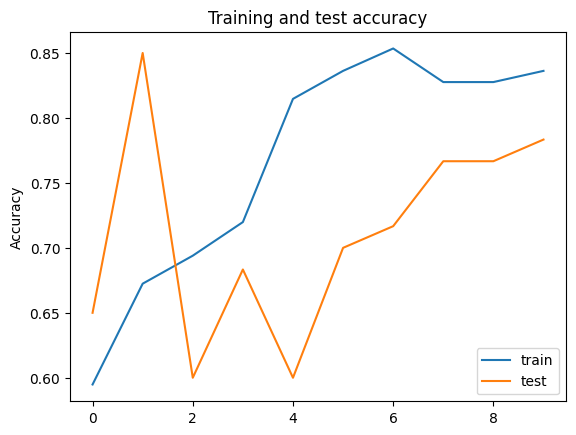

In [ ]:
acc = histroy.history['acc']
val_acc = histroy.history['val_acc']
loss = histroy.history['loss']
val_loss = histroy.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, label = 'train')
plt.plot(epochs, val_acc, label = 'test')
plt.ylabel("Accuracy")
plt.title("Training and test accuracy")
plt.legend(loc = "lower right")

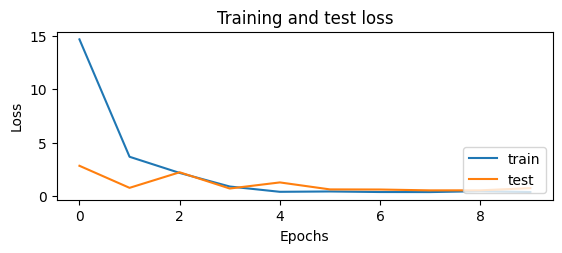

In [ ]:
plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()


# Evaluating Performance

In [ ]:
# def predict_image(filename):
#     image = Image.open(filename).resize((image_hight, image_width))
#     image_np = load_image_into_numpy_array(image)
#     exp = np.true_divide(image_np,255.0)
#     expanded = np.expand_dims(exp, axis = 0)
    # return model.predict(expanded)[0][0]

def predict_image(filename, model, image_height, image_width):
    # Load and resize the image
    image = Image.open(filename).resize((image_height, image_width))

    # Convert image to numpy array
    image_np = np.array(image)

    # Normalize the image
    normalized_image = image_np / 255.0

    # Expand dimensions to create a batch
    expanded_image = np.expand_dims(normalized_image, axis=0)

    # Make predictions using the model
    prediction = model.predict(expanded_image)

    # Assuming the model outputs a single value for prediction
    return prediction[0][0]


## Example image

In [ ]:


def show_df_row(row):
    image_path = row["filepath"]
    image = Image.open(image_path).resize((image_width, image_hight))
    img = load_image_into_numpy_array(image)
    exp = np.true_divide(img, 255.0)
    expanded = np.expand_dims(exp, axis=0)
    pred = model.predict(expanded)[0][0]
    guess = "neg"
    if pred > 0.5:
        guess = "pos"
    title = "Image: " + row["filename"] + " Label: " + row["label"] + " Guess: " + guess + " Score: " + str(pred)
    plt.title(title)
    plt.imshow(img)
    plt.show()
    return


In [ ]:
results = []
print(test_neg_dir)

for image in os.listdir(test_neg_dir):
    filename = test_neg_dir+"/"+image
    print(image)
    predict_image(filename, 256, 256)
    break
#     confidence = predict_image(image)
#     guess = 'pos' if confidence > 0.5 else 'neg'
#     results.append([filename, image, 'neg', guess, confidence])


# for image in os.listdir(test_pos_dir):
#     filename = test_neg_dir+"/"+image
#     confidence = predict_image(filename)
#     gues = 'pos' if confidence > 0.5 else 'neg'
#     results.append([filename, image, 'pos', guess, confidence])

# sorted_results = sorted(results, key = lambda x:x[4], reverse = True )
# df = pd.DataFrame(data = sorted_results, column = ['filepath', 'filename', 'label', 'guess', 'confidence'])

/content/medical-ai/images/Cardiomegaly/test/negative
00000091_006.jpg


TypeError: predict_image() missing 3 required positional arguments: 'model', 'image_height', and 'image_width'

In [ ]:
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

KeyError: 'filepath'